# Model Setup



---

## Overview
This notebook is for setting up a simple CNN-LSTM model to predict event-wise hurricane intensity using the prreproceesed data from the `era5_preprocessing.ipynb` notebook. 

1. **Data Preparation**: Load and preprocess the data.
2. **Model Definition**: Define a CNN-LSTM model.
3. **Model Training**: Train the model on the prepared data. 
4. **Model Evaluation**: Evaluate the model's performance on test data.   

---

## Imports


In [133]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xarray as xr


from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import  TimeDistributed, LSTM
import visualkeras
import tensorflow as tf


## Load the hurricane wise variable dataset

In this section,we will load the preprocessed dataset containing hurricane-wise environmental variables. This dataset is essential for training our CNN-LSTM model to predict hurricane intensity.


In [132]:
# load the preprocessed dataset
model_input = xr.open_dataset('../test_folder/input_predictands.nc')
model_input


<xarray.Dataset>
Dimensions:      (x: 5, y: 5, id: 69, lead: 80)
Coordinates:
  * x            (x) int64 0 1 2 3 4
  * y            (y) int64 0 1 2 3 4
    time         (id, lead) datetime64[ns] ...
    level        int32 ...
  * lead         (lead) int64 0 6 12 18 24 30 36 ... 438 444 450 456 462 468 474
  * id           (id) float64 0.0 1.0 1.5 1.667 2.0 ... 42.0 43.0 44.0 45.0 46.0
Data variables:
    r            (id, lead, y, x) float32 ...
    sp           (id, lead, y, x) float32 ...
    speed_shear  (id, lead, y, x) float32 ...
    sst          (id, lead, y, x) float64 ...
    u            (id, lead, y, x) float32 ...
    v            (id, lead, y, x) float32 ...
    vo           (id, lead, y, x) float32 ...
    rand_arr     (id, lead, y, x) float64 ...
    cor_params   (id, lead, y, x) float64 ...
    target       (id, lead) float64 ...

### Input Data prerpocessing steps
- Nan and padded values will be set to zero
- Set the train and test split
- normalize using the MinMaxScaler
- random shuffle for generalization


In [134]:
# remove the nan values and set it 
model_input = model_input.fillna(0)

# selecting the predictors (X) and expanding the dimensions

X_data = model_input[['u','v','vo','speed_shear','sp','r','cor_params']].to_array(dim='variable')

print(f'Dimensions are , features: {X_data.shape[0]}, Event: {X_data.shape[1]}, time(lead): {X_data.shape[2]}, lat: {X_data.shape[3]}, lon: {X_data.shape[4]}')

X_data = X_data.transpose('id', 'lead', 'y','x','variable')

print(f'X_data dimensions are: Event: {X_data.shape[0]}, time(lead): {X_data.shape[1]}, lat: {X_data.shape[2]}, lon: {X_data.shape[3]}, features: {X_data.shape[4]}')

Dimensions are , features: 7, Event: 69, time(lead): 80, lat: 5, lon: 5
X_data dimensions are: Event: 69, time(lead): 80, lat: 5, lon: 5, features: 7


In [135]:
# selecting the target variable (y)
Y_data = model_input['target']

# expanded the dimensions of Y_data to match the expected input shape for the model
#Y_data = np.expand_dims(Y_data, axis=-1)

print(f'Target dimensions are: Event: {Y_data.shape[0]}, time(lead): {Y_data.shape[1]}')

Target dimensions are: Event: 69, time(lead): 80


In [136]:
## 80% train and 20% test split

## random shuffled the events and split the data into training and testing sets
X_train , X_test , Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)


X_train_data = X_train.values
X_test_data = X_test.values
Y_train_data = Y_train.values
Y_test_data = Y_test.values




In [143]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

In [144]:
X_train_scaled = x_train_scaler.fit_transform(X_train_data.reshape(-1, X_train_data.shape[-1])).reshape(X_train_data.shape)
Y_train_scaled = y_train_scaler.fit_transform(Y_train_data.reshape(-1,1)).reshape(Y_train_data.shape)

X_test_scaled = x_test_scaler.fit_transform(X_test_data.reshape(-1, X_test_data.shape[-1])).reshape(X_test_data.shape)
Y_test_scaled = y_test_scaler.fit_transform(Y_test_data.reshape(-1,1)).reshape(Y_test_data.shape)


In [145]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_loss = tf.reduce_sum(squared_error * mask) / (tf.reduce_sum(mask) + 1e-6)
    return masked_loss

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    input_shape=(140, 5, 5, 7)
))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))  # <--- important!
model.add(TimeDistributed(Dense(1)))

model.summary()


/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 140, 5, 5, 16)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 140, 400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 140, 64)        │       119,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


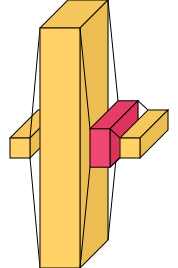

In [146]:
visualkeras.layered_view(model,scale_xy=0.6)


In [153]:
model.compile(optimizer='adam', metrics=['mae'] , loss=masked_mse)

model.fit(X_train_scaled, Y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 746ms/step - loss: 0.0584 - mae: 0.3861 - val_loss: 0.0414 - val_mae: 0.4813
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0465 - mae: 0.4589 - val_loss: 0.0613 - val_mae: 0.2496
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0660 - mae: 0.2521 - val_loss: 0.0268 - val_mae: 0.3000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0280 - mae: 0.3129 - val_loss: 0.0372 - val_mae: 0.4192
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0396 - mae: 0.4322 - val_loss: 0.0430 - val_mae: 0.4477
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0385 - mae: 0.4502 - val_loss: 0.0244 - val_mae: 0.3918
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0257 - mae: 0.3916 - val_loss: 0.0287 - val_mae: 0.3314
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0300 - mae: 0.3350 - val_loss: 0.0323 - val_mae: 0.3429
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0372 - mae:

In [154]:
predict_x = model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


In [155]:
def invert_add_meta(data,scalar,xr_data):
    data = scalar.inverse_transform(data.reshape(-1 ,1)).reshape(xr_data.shape)
    added_meta = xr.DataArray(data, coords=xr_data.coords, dims=xr_data.dims)
    return added_meta

predicted_wind_speed = invert_add_meta(predict_x, y_test_scaler, Y_test)

observed_wind_speeds = Y_test

final_dset = predicted_wind_speed.to_dataset(name='predicted_wind_speed')
final_dset['observed_wind_speed'] = observed_wind_speeds
                                                    
final_dft = final_dset.to_dataframe().reset_index()

# set 0.0 as nan in observed_wind_speed
final_dft['observed_wind_speed'] = final_dft['observed_wind_speed'].replace(0.0, np.nan)

# whenever the predicted_wind_speed is nan, sdrop the entire row

final_dft = final_dft.dropna(how='any',axis=0)

final_pivot_col = final_dft.drop(columns=['time','level'])

In [156]:
final_pivot_col

,id,lead,predicted_wind_speed,observed_wind_speed
0,41.0,0,35.869568,46.0
1,41.0,6,36.969219,51.0
2,41.0,12,32.749451,56.0
3,41.0,18,31.629051,61.0
4,41.0,24,33.868134,65.0
...,...,...,...,...
1064,35.0,144,45.388672,58.5
1065,35.0,150,40.030651,53.5
1066,35.0,156,39.191105,48.5
1067,35.0,162,34.868706,46.0


/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_45613/738888654.py:12: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_45613/738888654.py:25: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


Text(0, 0.5, 'Wind Speed (m/s)')

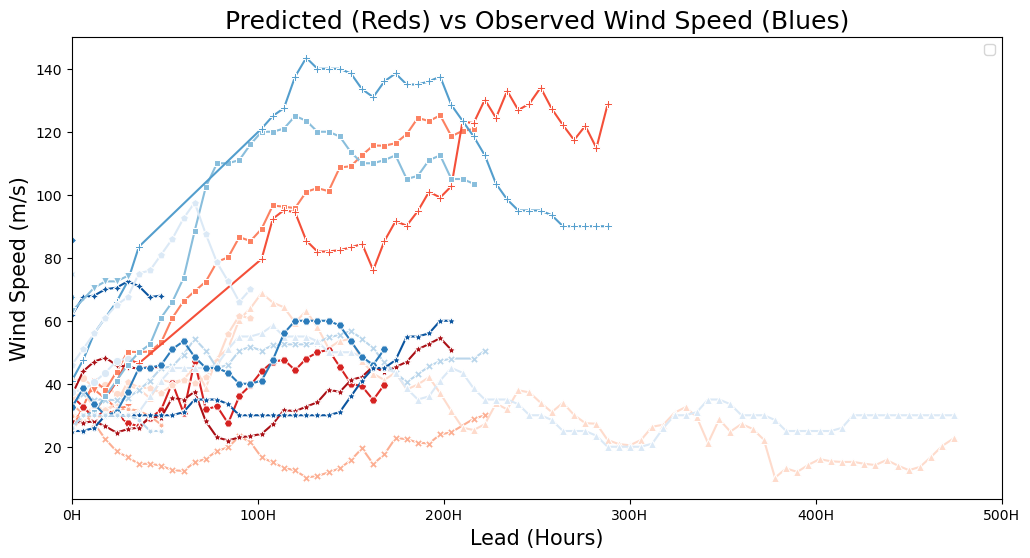

In [157]:
import seaborn as sbs 

import seaborn as sns
import matplotlib.pyplot as plt

# Define two different palettes
palette1 = sns.color_palette("Reds")           # for predicted
palette2 = sns.color_palette("Blues")            # for observed

fig,ax = plt.subplots(figsize=(12, 6))
# First lineplot (predicted) with palette1
sns.lineplot(
    data=final_pivot_col,
    x='lead',
    y='predicted_wind_speed',
    hue='id',
    style='id',
    markers=True,
    dashes=False,
    palette=palette1,
    legend='brief'
,ax=ax)

# Second lineplot (observed) with palette2
sns.lineplot(
    data=final_pivot_col,
    x='lead',
    y='observed_wind_speed',
    hue='id',
    style='id',
    markers=True,
    dashes=False,
    palette=palette2,
    legend='brief'
,ax=ax)
plt.legend('')



# add H to the end of xticks
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([f'{int(tick)}H' for tick in xticks])
ax.set_xlim(0, 500)


ax.set_xlabel('Lead (Hours)',fontsize=15)
ax.set_title('Predicted (Reds) vs Observed Wind Speed (Blues)',fontsize=18)

ax.set_ylabel('Wind Speed (m/s)',fontsize=15)
#sbs.lineplot(data=final_pivot_col, x='lead', y='observed_wind_speed', hue='id', style='id', markers=True, dashes=False)